In [246]:
# 1. Carregar dados

import pandas as pd

# Carregar o dataset
df = pd.read_csv('./data/dataset.csv')
df.head()

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level,Outcome Variable
0,Influenza,Yes,No,Yes,Yes,19,Female,Low,Normal,Positive
1,Common Cold,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
2,Eczema,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
3,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive
4,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive


In [247]:
# 2. Preparação e divisão de dados

from sklearn.model_selection import train_test_split

df['Fever'] = df['Fever'].map({'Yes': 1, 'No': 0})
df['Cough'] = df['Cough'].map({'Yes': 1, 'No': 0})
df['Fatigue'] = df['Fatigue'].map({'Yes': 1, 'No': 0})
df['Difficulty Breathing'] = df['Difficulty Breathing'].map({'Yes': 1, 'No': 0})
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['Blood Pressure'] = df['Blood Pressure'].map({'Low': 0, 'Normal': 1, 'High': 2})
df['Cholesterol Level'] = df['Cholesterol Level'].map({'Low': 0, 'Normal': 1, 'High': 2})
df['Outcome Variable'] = df['Outcome Variable'].map({'Positive': 1, 'Negative': 0})

# Filter rows where Disease is 'Influenza'
df = df[df['Disease'] == 'Influenza']

X = df.drop('Disease', axis=1)
y = df['Outcome Variable']

# Dividir o dataset em treino e teste
# Training set: 80% of the data
# Testing set: 20% of the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42)

In [248]:
# Verificação de tipos de valores

df.dtypes

Disease                 object
Fever                    int64
Cough                    int64
Fatigue                  int64
Difficulty Breathing     int64
Age                      int64
Gender                   int64
Blood Pressure           int64
Cholesterol Level        int64
Outcome Variable         int64
dtype: object

In [249]:
# 3. Normalização

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = (scaler.transform(X_test))

In [250]:
# 4. Treinar modelo - Árvore de Decisão

from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(
    random_state=42, max_depth=30, min_samples_split=2, min_samples_leaf=1)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=30, random_state=42)

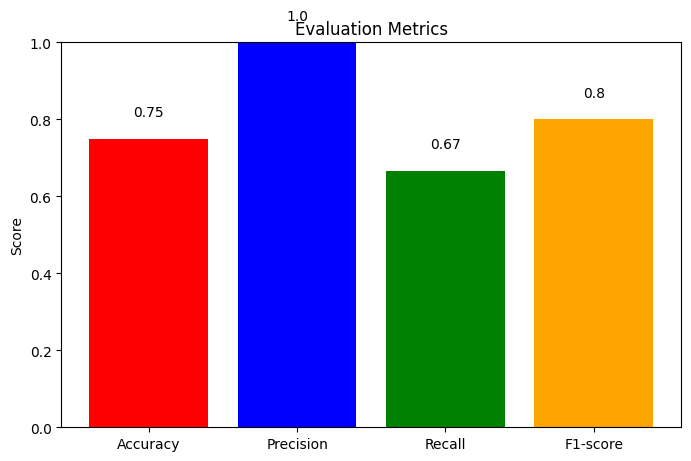

In [251]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Example of evaluation with accuracy, classification_report, and other metrics
y_pred = model.predict(X_test)

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Plotting precision, recall, and f1-score
labels = ['Accuracy','Precision', 'Recall', 'F1-score']
metrics_values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, metrics_values, color=['red', 'blue', 'green', 'orange'])
plt.title('Evaluation Metrics')
plt.ylim(0.0, 1.0)  # Set y-axis limits to [0, 1] for better visualization
plt.ylabel('Score')

# Adding text annotations on top of each bar
for bar, value in zip(bars, metrics_values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(value, 2), ha='center', va='bottom')

plt.show()

In [252]:
# 6. Validação cruzada

import numpy as np

from sklearn.model_selection import StratifiedKFold

# Definir o número de dobras e a estratificação
n_splits = 2
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Realizar a validação cruzada manualmente
scores = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Treinar e avaliar seu modelo aqui
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    scores.append(score)

print("Cross-validation scores:", scores)
print("Mean cross-validation score:", np.mean(scores))

Cross-validation scores: [0.5, 0.75]
Mean cross-validation score: 0.625


In [253]:
# 7. Grid Search
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier

# Generate example dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_classes=2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize StratifiedKFold for cross-validation
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(dt, param_grid, cv=strat_kfold)

# Fit GridSearchCV using the original dataset
grid_search.fit(X, y)

# Print best parameters and best cross-validation score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best cross-validation score: 0.8299999999999998
